In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable

In [2]:
np.random.seed(0)


In [3]:
!ls ./dataset/input/pretrained-pytorch-models/

densenet161-17b70270.pth         resnet50-19c8e357.pth
inception_v3_google-1a9a5a14.pth squeezenet1_0-a815701f.pth
resnet18-5c106cde.pth            squeezenet1_1-f364aa15.pth


In [4]:
cache_dir = expanduser(join('~', '.torch'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [5]:
!cp ./dataset/input/pretrained-pytorch-models/* ~/.torch/models/

In [6]:
!ls ~/.torch/models

densenet161-17b70270.pth         resnet50-19c8e357.pth
inception_v3_google-1a9a5a14.pth squeezenet1_0-a815701f.pth
resnet18-5c106cde.pth            squeezenet1_1-f364aa15.pth


In [7]:
!ls ./dataset/

DogHierarchy.csv           new_labels_two_columns.csv
input                      sample_submission.csv
labels.csv                 test
new_labels.csv             train


In [3]:
INPUT_SIZE = 224
NUM_CLASSES = 16
data_dir = './dataset/'
#labels = pd.read_csv(join(data_dir, 'labels.csv'))
labels = pd.read_csv(join(data_dir, 'new_labels_two_columns.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [4]:
selected_breed_list=['domestic_dog','spitz','samoyed','pomeranian','hound_dog','scottish_deerhound','afghan_hound','beagle',
                     'toy_dog','shih-tzu','maltese_dog','japanese_spaniel','terrier','cairn','tibetan_terrier','airedale']
labels = labels[labels['breed'].isin(selected_breed_list)]
#labels

In [96]:
selected_breed_list

['domestic_dog',
 'spitz',
 'samoyed',
 'pomeranian',
 'hound_dog',
 'scottish_deerhound',
 'afghan_hound',
 'beagle',
 'toy_dog',
 'shih-tzu',
 'maltese_dog',
 'japanese_spaniel',
 'terrier',
 'cairn',
 'tibetan_terrier',
 'airedale']

In [5]:
#selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
selected_breed_list=['domestic_dog','spitz','samoyed','pomeranian','hound_dog','scottish_deerhound','afghan_hound','beagle',
                     'toy_dog','shih-tzu','maltese_dog','japanese_spaniel','terrier','cairn','tibetan_terrier','airedale']
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.8)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(2645, 17) (661, 17)


In [13]:
train.head()

breed,id,afghan_hound,airedale,beagle,cairn,domestic_dog,hound_dog,japanese_spaniel,maltese_dog,pomeranian,samoyed,scottish_deerhound,shih-tzu,spitz,terrier,tibetan_terrier,toy_dog
587,2e9c04fbf919d4bc2222a64fb15bad75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,02e7b5a86cec57f5935374946d4f5dc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2180,a8dcd9886518ec9c154e3a1bee625f9a,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2155,a72fac01497e296e32fab4192df57531,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1779,8bd9f03c437e44fc390e90d05b1af1bf,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
train.columns

Index(['id', 'afghan_hound', 'airedale', 'beagle', 'cairn', 'domestic_dog',
       'hound_dog', 'japanese_spaniel', 'maltese_dog', 'pomeranian', 'samoyed',
       'scottish_deerhound', 'shih-tzu', 'spitz', 'terrier', 'tibetan_terrier',
       'toy_dog'],
      dtype='object', name='breed')

In [21]:
#for i in train.columns:
    #print(i)
breed_dict={}
for c, value in enumerate(train.columns, 0):
    if c>0:
        breed_dict[value]=c-1
        #print(c-1, value)
breed_dict

{'afghan_hound': 0,
 'airedale': 1,
 'beagle': 2,
 'cairn': 3,
 'domestic_dog': 4,
 'hound_dog': 5,
 'japanese_spaniel': 6,
 'maltese_dog': 7,
 'pomeranian': 8,
 'samoyed': 9,
 'scottish_deerhound': 10,
 'shih-tzu': 11,
 'spitz': 12,
 'terrier': 13,
 'tibetan_terrier': 14,
 'toy_dog': 15}

In [27]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        
        labels = self.labels.iloc[idx, 1:].as_matrix().astype('float')
        #print("labels",labels)
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [28]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Scale(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, data_dir+'train/', transform=ds_trans)
valid_ds = DogsDataset(valid, data_dir+'train/', transform=ds_trans)



In [47]:
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)

In [48]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([4, 3, 224, 224]) torch.Size([4])


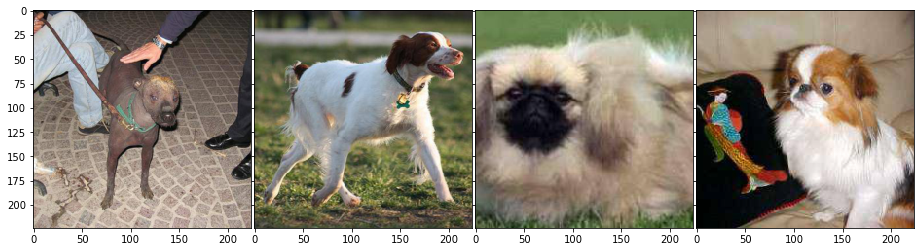

In [49]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

In [50]:
use_gpu = torch.cuda.is_available()
resnet = models.resnet18(pretrained=True)
inputs, labels = next(iter(train_dl))
if use_gpu:
    resnet = resnet.cuda()
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())   
else:
    inputs, labels = Variable(inputs), Variable(labels)
outputs = resnet(inputs)
outputs.size()

torch.Size([4, 1000])

In [51]:
dloaders = {'train':train_dl, 'valid':valid_dl}

In [52]:
phase = 'train'


# extract features

In [21]:
model = models.resnet18(pretrained=True)
# remove last fully-connected layer
new_classifier = nn.Sequential(*list(model.children())[:-1])
model.classifier = new_classifier

In [38]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        #self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        #self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        #self.init_weights()
        
    #def init_weights(self):
        #"""Initialize the weights."""
        #self.linear.weight.data.normal_(0.0, 0.02)
        #self.linear.bias.data.fill_(0)
        
    def forward(self, images):
        """Extract the image feature vectors."""
        features = self.resnet(images)
        features = Variable(features.data)
        features = features.view(features.size(0), -1)
        #features = self.bn(self.linear(features))
        return features

In [97]:
all=[]
id=0
model = EncoderCNN()
model.train(True)
for inputs, labels in dloaders[phase]:
    inputs, labels = Variable(inputs), Variable(labels)
    #out=[id]
    #print(len(inputs))
    if id<50:
        outputs = model(inputs)
        for i in range(len(inputs)):
            
            out=[id]
            #if id>2500:
            print("id",id)
            features=outputs[i]
            #print("len(features.data)",len(features.data))
            lab=labels.data[i]
            out.extend(features.data)
            out.append(int(lab))
            id=id+1
            all.append(out)
    

id 0
id 1
id 2
id 3
id 4
id 5
id 6
id 7
id 8
id 9
id 10
id 11
id 12
id 13
id 14
id 15
id 16
id 17
id 18
id 19
id 20
id 21
id 22
id 23
id 24
id 25
id 26
id 27
id 28
id 29
id 30
id 31
id 32
id 33
id 34
id 35
id 36
id 37
id 38
id 39
id 40
id 41
id 42
id 43
id 44
id 45
id 46
id 47
id 48
id 49
id 50
id 51


In [101]:
np.savetxt('test50.txt', all,fmt='%1.5f') 
#np.savetxt('tmp.txt',a, fmt='%1.3f')